## Exploratory data analysis

In [1]:
import subprocess
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Merge all results into one file.
subprocess.run(["py", "process_data.py", "--merge-results"])

In [2]:
def load_repo_csv(repo_file):
    repo = pd.read_csv(f"data/results/{repo_file}", index_col=0)
    repo['date'] = pd.to_datetime(repo['date'], utc=True)
    return repo

Dataframes for individual repositories.

In [19]:
repo_files = list(set(os.listdir("data/results")) - {"_all_results.csv", "tiny"})

max_repos_load = 5
repos = {repo_file: load_repo_csv(repo_file) for repo_file in repo_files[:max_repos_load]}
repos.keys()

dict_keys(['virtualenv.csv', 'python-fire.csv', 's3transfer.csv', 'yarl.csv', 'graphviz.csv'])

Dataframe for all results.

In [4]:
all_results = pd.read_csv("data/results/_all_results.csv", index_col=0)
all_results['date'] = pd.to_datetime(all_results['date'], utc=True)

all_results.shape

(11382, 25)

In [5]:
all_results.head()

,hash,author,date,commit_message,is_merge,lines_changed,insertions,deletions,dmm_unit_size,dmm_unit_complexity,...,radon_avg_cc,radon_avg_MI,radon_avg_vocabulary,radon_avg_length,radon_avg_volume,radon_avg_difficulty,radon_avg_effort,radon_avg_time,radon_avg_bugs,repo_name
ID,,,,,,,,,,,,,,,,,,,,,
0,bdc4fd7bedf1db6bdacd53ac6c0fa62a998f91b3,Scott Shawcroft,2016-12-02 02:34:46+00:00,First version of I2CDevice,False,192,192,0,1.0,1.0,...,1.333333,43.904081,2.000000,2.000000,2.000000,0.500000,1.000000,0.055556,0.000667,Adafruit_CircuitPython_BusDevice
1,8ce1de7439351845c62f3a83b5c1076f82e268e9,Scott Shawcroft,2016-12-02 23:58:08+00:00,Add SPIDevice for SPI device locking and setti...,False,97,97,0,1.0,1.0,...,1.333333,51.805932,2.000000,2.000000,2.000000,0.500000,1.000000,0.055556,0.000667,Adafruit_CircuitPython_BusDevice
2,a7d11f8898e3232140e0c43ba77856de9be7a64d,Tony DiCola,2016-12-12 08:19:40+00:00,Optimization: remove read/write from SPI devic...,False,34,1,33,0.0,0.0,...,1.400000,59.130079,2.000000,2.000000,2.000000,0.500000,1.000000,0.055556,0.000667,Adafruit_CircuitPython_BusDevice
3,b5cadae8b1b6b4962492823065d1dc036ae5c4cd,Tony DiCola,2016-12-13 01:46:58+00:00,Add init .py for module structure.,False,1,1,0,NaN,NaN,...,1.333333,67.870621,1.333333,1.333333,1.333333,0.333333,0.666667,0.037037,0.000444,Adafruit_CircuitPython_BusDevice
4,a2bf3b10f4f2511f60d4ddd27795d72cc3ec3b2a,Scott Shawcroft,2017-01-06 01:42:29+00:00,Add setup.py so we can distribute via pip.,False,57,57,0,NaN,NaN,...,1.400000,79.565040,1.000000,1.000000,1.000000,0.250000,0.500000,0.027778,0.000333,Adafruit_CircuitPython_BusDevice


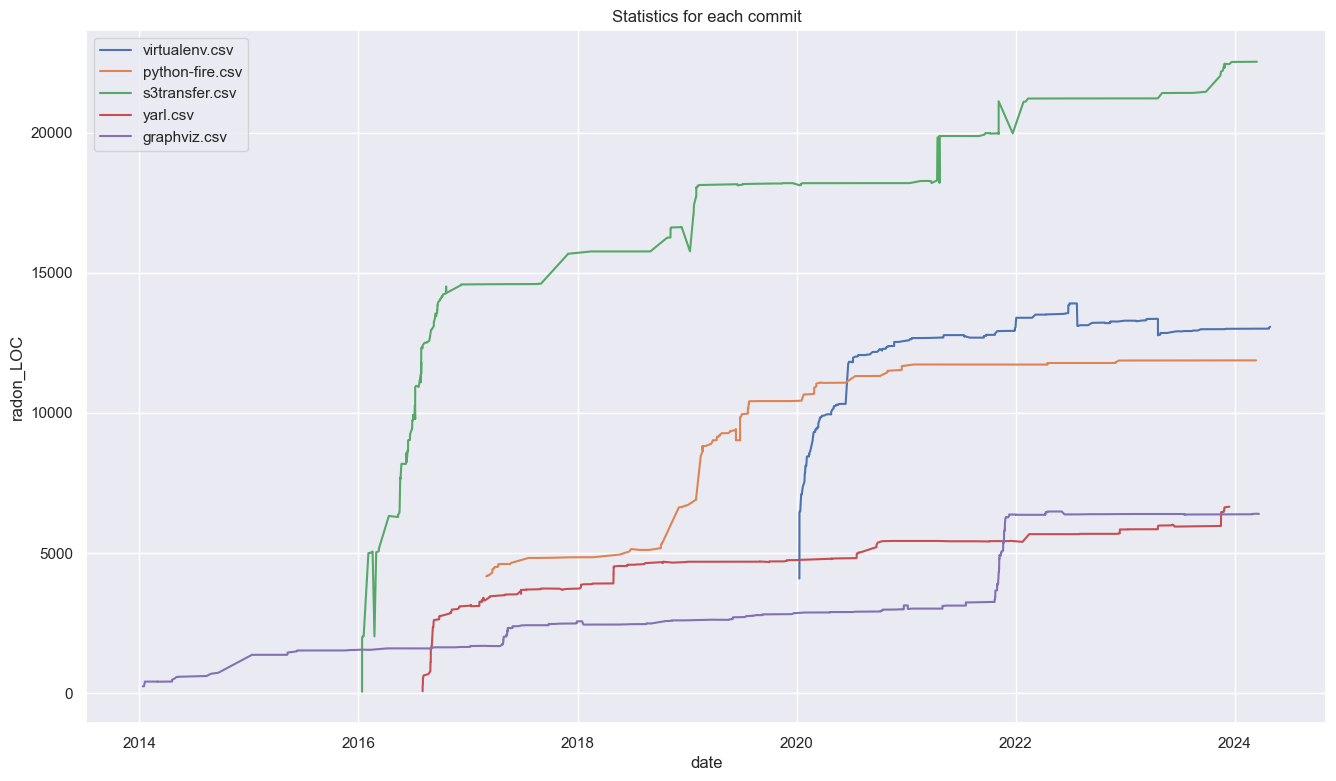

In [24]:
sns.set_theme(rc={'figure.figsize':(16,9)})

for repo_name, df in repos.items():
    # sns.lineplot(data=df, x='date', y='lines_changed', label='Lines changed (additions + deletions)')
    sns.lineplot(data=df, x='date', y='radon_LOC', label=repo_name)
# plt.legend()
plt.title("Statistics for each commit");

Shapley analysis.

In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

Mean Squared Error: 1134138.151144833
Mean Absolute Error: 496.22453853484114
R-squared: 0.9864493992254189


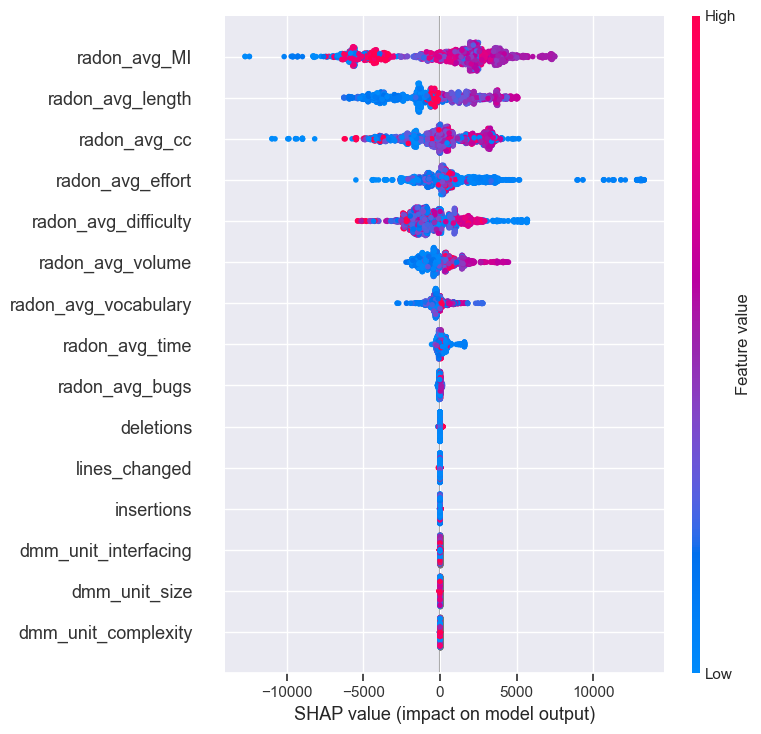

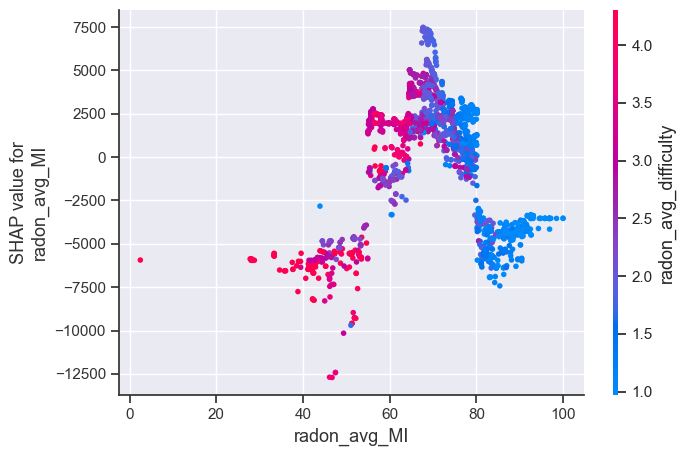

C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


IndexError: tuple index out of range

In [28]:
DATA_FILE = "data/results/_all_results.csv"

data = pd.read_csv(DATA_FILE, usecols=["lines_changed", "insertions", "deletions", "dmm_unit_size", "dmm_unit_complexity", "dmm_unit_interfacing", "radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments", "radon_avg_cc", "radon_avg_MI", "radon_avg_vocabulary", "radon_avg_length", "radon_avg_volume", "radon_avg_difficulty", "radon_avg_effort", "radon_avg_time", "radon_avg_bugs"])

y = data["radon_LOC"]
X = data.drop(["radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset.
train_data = lgb.Dataset(X_train, label=y_train)

# Hyperparameters for the LightGBM model.
lgbm_params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0
}

model = lgb.train(lgbm_params, train_data, num_boost_round=100)

y_pred = model.predict(X_test)

# Evaluate, show metrics.
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)


# Create a SHAP explainer
explainer = shap.Explainer(model)

# Calculate Shapley values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Plot the Shapley dependence plot for a specific feature
shap.dependence_plot("radon_avg_MI", shap_values, X_test)

# Calculate the Shapley values for a single instance.
instance = X_test.iloc[0]
shap_values_single = explainer.shap_values(instance)

print("Shapley Values for Single Instance:")
print(shap_values_single)

instance = X_test.iloc[4]
shap_values_single = explainer.shap_values(instance)

# Plot the waterfall plot for the 5th element
shap.waterfall_plot(shap.Explanation(values=shap_values_single[0], base_values=model.predict(X_train.mean().values.reshape(1, -1))), max_display=10)

shap.waterfall_plot(shap.Explanation(values=shap_values[1], base_values=explainer.expected_value[1]), feature_names=X_test.columns.tolist(), max_display=10, show=False)


